## Install Packages

In [1]:
# pyspark

!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=02014ac53b0e55db432a6758da62c84cd451fce2d8552e5623a271e566a372a5
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
!pip install -U textblob

In [3]:
!pip install tensorflow

In [4]:
!pip install gensim

In [5]:
!pip install wordcloud

In [6]:
!pip install plotly

In [7]:
!pip install statsmodels

In [8]:
!pip install scikit-learn

In [42]:
!pip install statsmodels

## Import Libraries

In [1]:
# - - - - - - - - - - - - - - - - - spark - - - - - - - - - - - - - -

from pyspark.sql import SparkSession

# - - - - - - - - - - - - - - - - - base - - - - - - - - - - - - - -

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# - - - - - - - - - - - - - - - - - nlp - - - - - - - - - - - - - -

import gensim
import nltk
import re
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer

# - - - - - - - - - - - - - - - - - time series - - - - - - - - - - - - - -


from statsmodels.tsa.seasonal import seasonal_decompose
from nltk.corpus import stopwords as nltk_stopwords 

# - - - - - - - - - - - - - - - - - ml - - - - - - - - - - - - - -

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional,Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# - - - - - - - - - - - - - - - - - confusion matrix - - - - - - - - - - - - - -

from sklearn.metrics import confusion_matrix

## Create Spark

In [ ]:
# Create a Spark session
spark = SparkSession.builder.appName('ProjectTweets').getOrCreate()

In [11]:
# spark

spark

## Viewing Data

In [13]:
# upload dataset 
file_path = '/content/ProjectTweets.csv'  # Replace with the actual path to your dataset
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the DataFrame
df.show()

+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|  0|1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|  1|1467810672|        Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|                                                                                               is upset that he ...|
|  2|1467810917|        Mon Apr 06 22:19:...|NO_QUERY|       mattycus|                                                                                               @Kenichan I dived...|
|  3|1467811184|        Mon Apr 06 22:19:...|NO_QUERY|        Ell

In [14]:
df.show(1)

+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|  0|1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|  1|1467810672|        Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|                                                                                               is upset that he ...|
+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
only showing top 1 row



schema and column names

In [15]:
df.columns


['0',
 '1467810369',
 'Mon Apr 06 22:19:45 PDT 2009',
 'NO_QUERY',
 '_TheSpecialOne_',
 "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"]

In [16]:
df.printSchema()

root
 |-- 0: integer (nullable = true)
 |-- 1467810369: long (nullable = true)
 |-- Mon Apr 06 22:19:45 PDT 2009: string (nullable = true)
 |-- NO_QUERY: string (nullable = true)
 |-- _TheSpecialOne_: string (nullable = true)
 |-- @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D: string (nullable = true)



In [17]:
df.collect()

[Row(0=1, 1467810369=1467810672, Mon Apr 06 22:19:45 PDT 2009='Mon Apr 06 22:19:49 PDT 2009', NO_QUERY='NO_QUERY', _TheSpecialOne_='scotthamilton', @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D="is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"),
 Row(0=2, 1467810369=1467810917, Mon Apr 06 22:19:45 PDT 2009='Mon Apr 06 22:19:53 PDT 2009', NO_QUERY='NO_QUERY', _TheSpecialOne_='mattycus', @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D='@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds'),
 Row(0=3, 1467810369=1467811184, Mon Apr 06 22:19:45 PDT 2009='Mon Apr 06 22:19:57 PDT 2009', NO_QUERY='NO_QUERY', _TheSpecialOne_='ElleCTF', @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D='my whole

In [18]:
df.take(1)

[Row(0=1, 1467810369=1467810672, Mon Apr 06 22:19:45 PDT 2009='Mon Apr 06 22:19:49 PDT 2009', NO_QUERY='NO_QUERY', _TheSpecialOne_='scotthamilton', @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D="is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!")]

## Convert PySpark DataFrame to Pandas

In [34]:
# Convert PySpark DataFrame to Pandas DataFrame
pandas_project = project.toPandas()

# Rename the columns
pandas_project.rename(columns={0: 'target', 1: 'id', 2: 'date', 3: 'query', 4: 'username', 5: 'content'}, inplace=True)

# Display the Pandas DataFrame
print(pandas_project)

               0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  \
0              1  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
1              2  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
2              3  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
3              4  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4              5  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY   
...          ...         ...                           ...       ...   
1599994  1599995  2193601966  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599995  1599996  2193601969  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599996  1599997  2193601991  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599997  1599998  2193602064  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599998  1599999  2193602129  Tue Jun 16 08:40:50 PDT 2009  NO_QUERY   

         _TheSpecialOne_  \
0          scotthamilton   
1               mattycus   
2                ElleCTF   
3                 Karol

In [35]:
project = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the DataFrame
df.show()


+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|  0|1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|  1|1467810672|        Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|                                                                                               is upset that he ...|
|  2|1467810917|        Mon Apr 06 22:19:...|NO_QUERY|       mattycus|                                                                                               @Kenichan I dived...|
|  3|1467811184|        Mon Apr 06 22:19:...|NO_QUERY|        Ell

In [61]:
# Rename the columns
df = df.withColumnRenamed("_1", "target") \
       .withColumnRenamed("_2", "id") \
       .withColumnRenamed("_3", "date") \
       .withColumnRenamed("_4", "query") \
       .withColumnRenamed("_5", "username") \
       .withColumnRenamed("_6", "content")

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()



In [40]:
pandas_df.head()

0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY _TheSpecialOne_  \
0  1  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   scotthamilton   
1  2  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY        mattycus   
2  3  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         ElleCTF   
3  4  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          Karoli   
4  5  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY        joy_wolf   

  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  
0  is upset that he can't update his Facebook by ...                                                                   
1  @Kenichan I dived many times for the ball. Man...                                                                   
2    my whole body feels itchy and like its on fire                                                                    
3  @nationwideclass no, it's not behaving at all....                                                                   
4                      @Kwesidei not the whole crew

In [2]:
#read dataset
project = pd.read_csv("ProjectTweets.csv", encoding = 'latin', header=None)

In [3]:
project = project.rename(columns={0: 'target', 1: 'ids', 2: 'date', 3: 'flag', 4: 'user', 5: 'text'})

In [5]:
project.head()

target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       1  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       2  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       3  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       4  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....

## Dtypes

In [5]:
project.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

## Cheking Missing Values

In [6]:
project.isna().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

## Shape

In [8]:
project.shape

(1600000, 6)

## Information about the dataset

In [9]:
project.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


## Data Visualization

<Axes: >

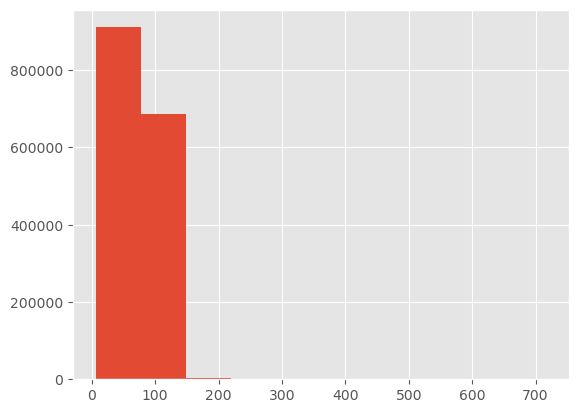

In [13]:
project['text'].str.len().hist()

<Axes: >

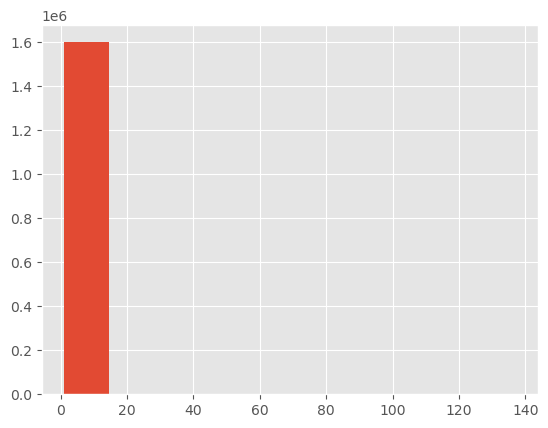

In [18]:
project['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

In [21]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tolga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

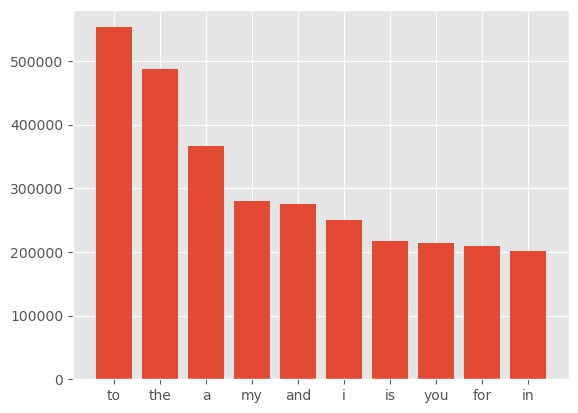

In [24]:
plot_top_stopwords_barchart(project['text'])

In [29]:
from nltk.corpus import stopwords
from collections import  Counter

In [30]:
def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)

c:\Users\tolga\anaconda3\envs\myenv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tolga\anaconda3\envs\myenv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tolga\anaconda3\envs\myenv\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\tolga\anaconda3\envs\myenv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype

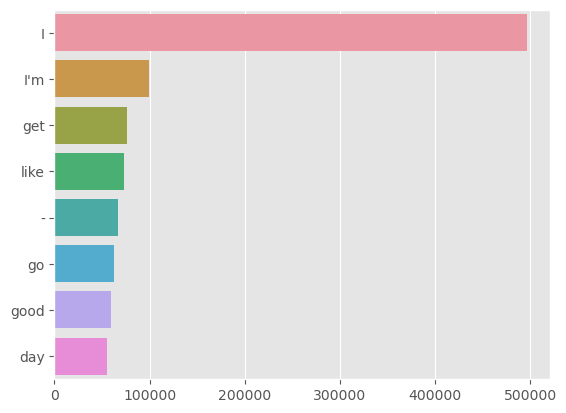

In [31]:
plot_top_non_stopwords_barchart(project['text'])

## World Cloud

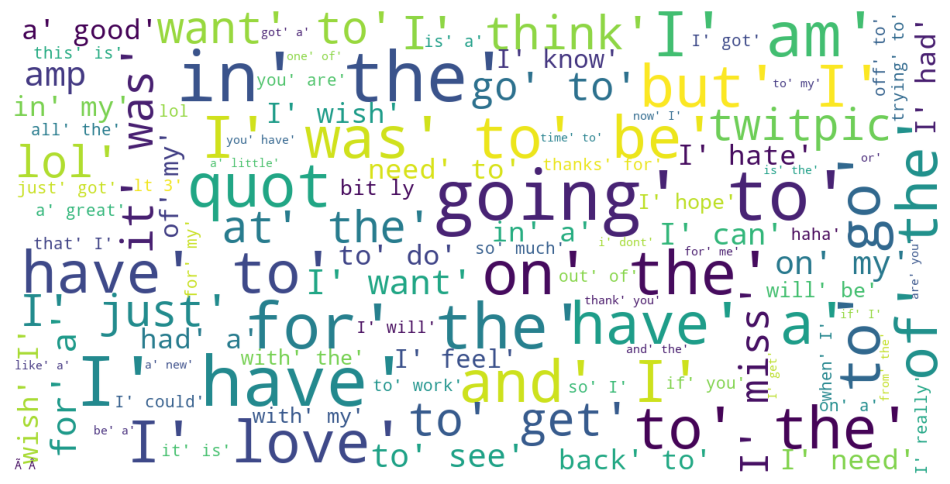

In [32]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

### Separating input feature and label

In [91]:
X=project.text
y=project.target

### Plot a cloud of words for negative tweets

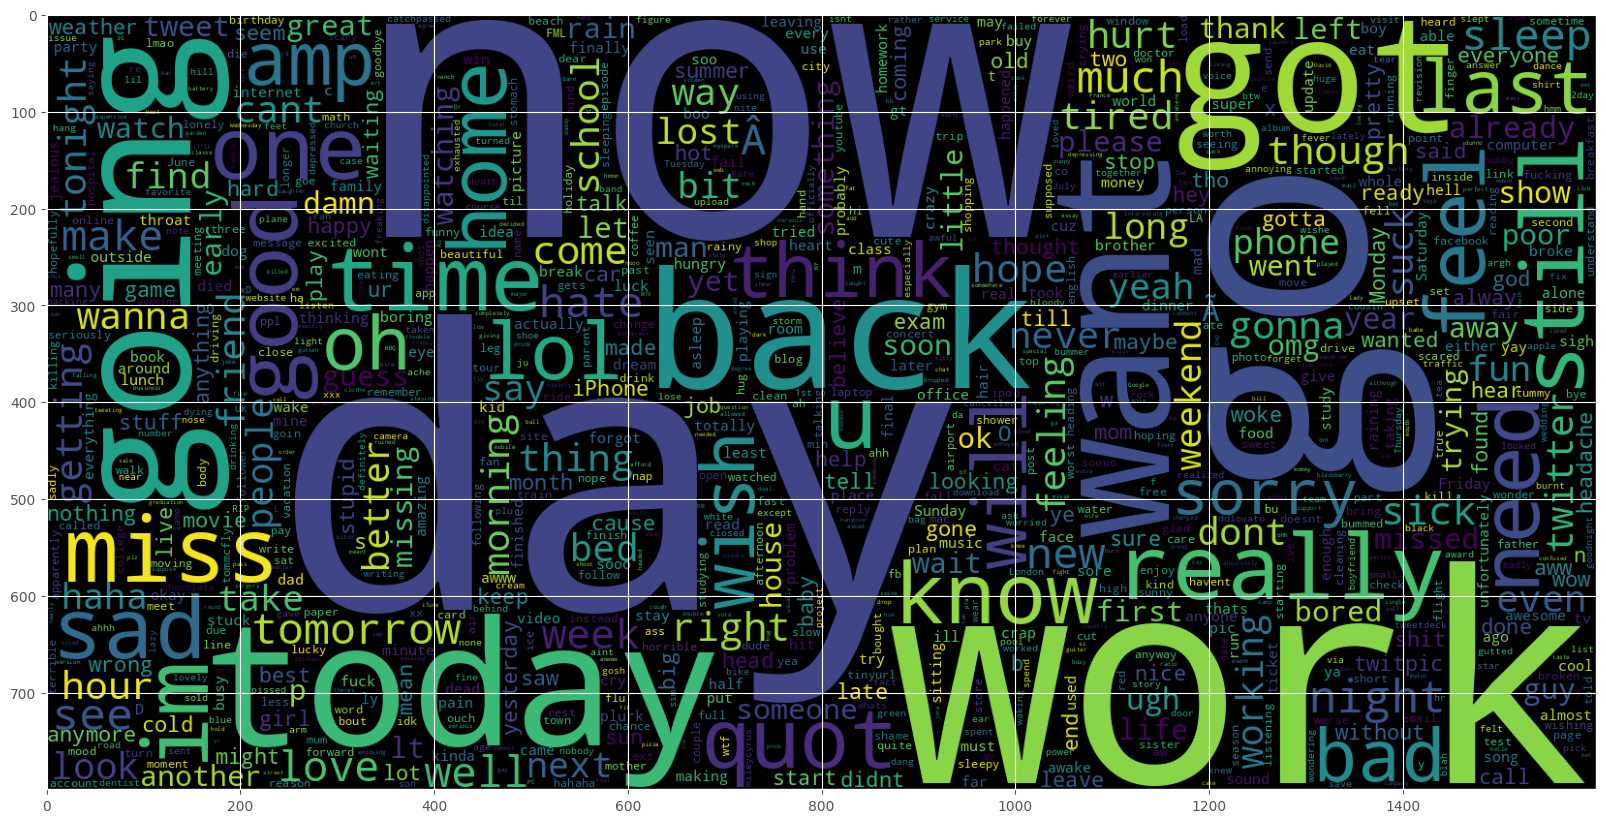

In [93]:
data_neg = project['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

### Plot a cloud of words for positive tweets

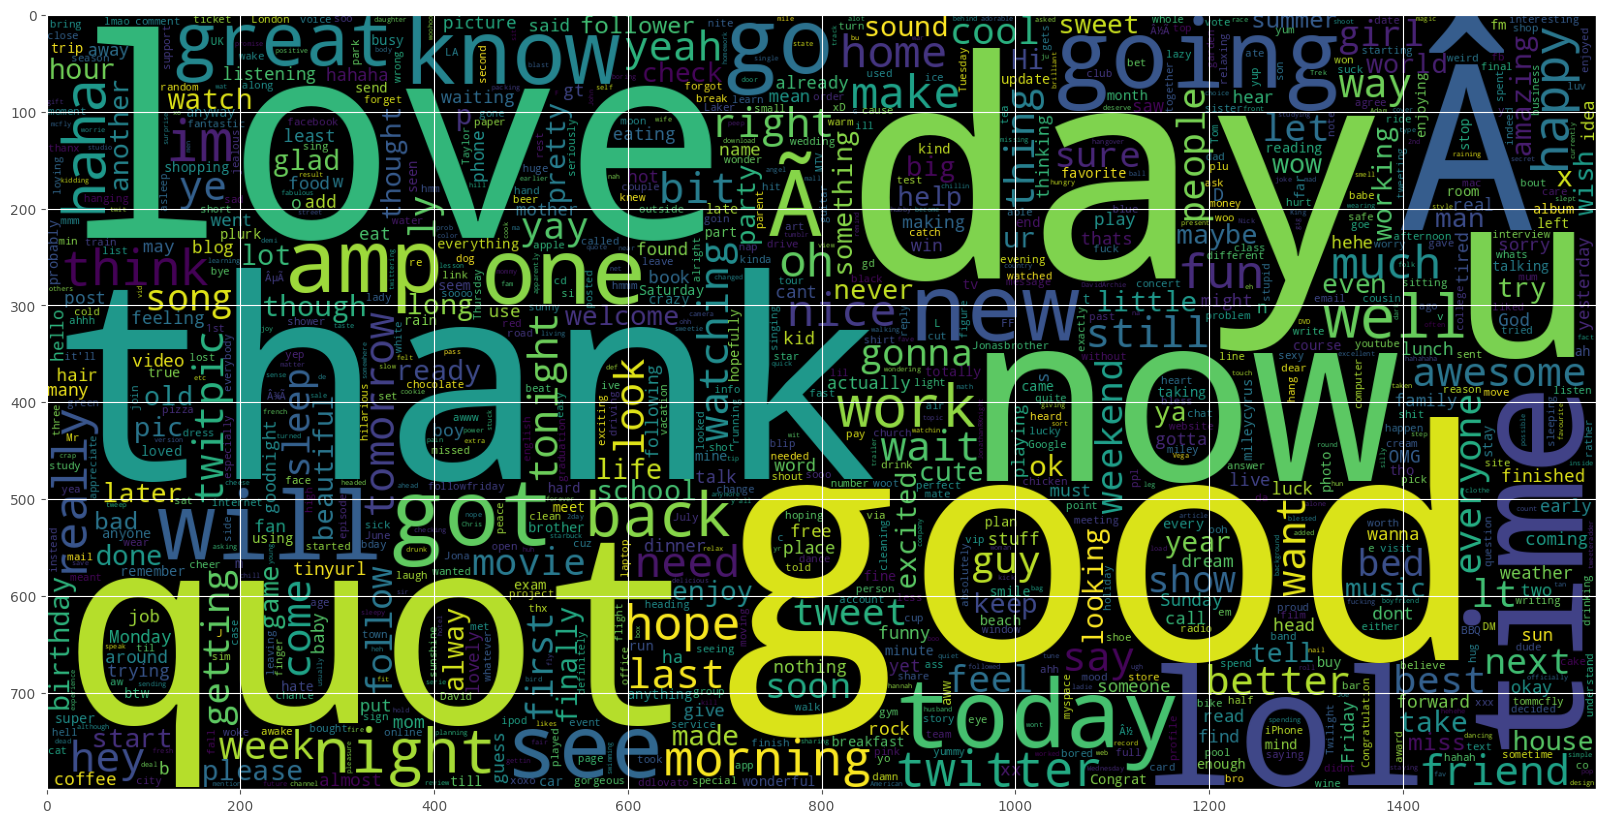

In [97]:
data_pos = project['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

## Hastag Analysis

Top 10 Hashtags:
#followfriday: 2288
#fb: 1765
#squarespace: 867
#ff: 822
#seb-day: 498
#iranelection: 485
#: 472
#musicmonday: 397
#1: 391
#fail: 343


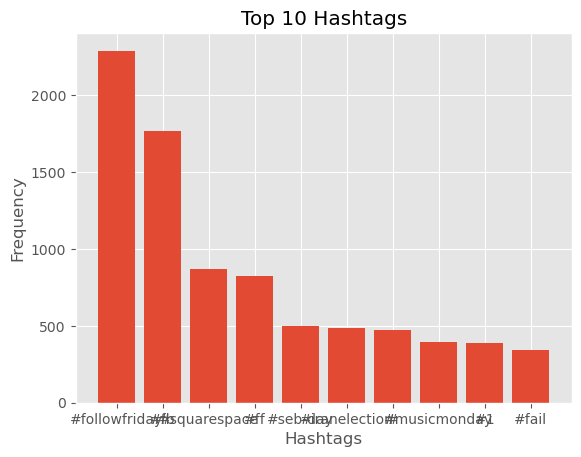

In [38]:
# Extract hashtags from the 'text' column
def extract_hashtags_from_text(text):
    words = text.split()
    return [word.lower() for word in words if word.startswith("#")]

# Apply the function to the 'text' column
project['hashtags'] = project['text'].apply(extract_hashtags_from_text)

# Flatten the list of hashtags
all_hashtags = [tag for sublist in project['hashtags'].tolist() for tag in sublist]

# Analyze and plot hashtag frequencies
top_n = 10
hashtag_counts = Counter(all_hashtags)
top_hashtags = dict(hashtag_counts.most_common(top_n))

# Display the list of hashtags and their frequencies
print("Top {} Hashtags:".format(top_n))
for hashtag, frequency in top_hashtags.items():
    print(f"{hashtag}: {frequency}")

# Plot the hashtag frequencies
plt.bar(top_hashtags.keys(), top_hashtags.values())
plt.xlabel('Hashtags')
plt.ylabel('Frequency')
plt.title('Top {} Hashtags'.format(top_n))
plt.show()

## Preprocessing Dataset

### Encoding

In [23]:
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

In [24]:
temp = []
#Splitting pd.Series to list
data_to_list = project["text"].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

[' - Awww, thats a bummer. You shoulda got David Carr of Third Day to do it. ;D',
 'is upset that he cant update his Facebook by texting it... and might cry as a result School today also. Blah!',
 'I dived many times for the ball. Managed to save 50% The rest go out of bounds',
 'my whole body feels itchy and like its on fire ',
 'no, its not behaving at all. im mad. why am i here? because I cant see you all over there. ']

In [25]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        

data_words = list(sent_to_words(temp))
print(data_words[:10],'\n')

[['awww', 'thats', 'bummer', 'you', 'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it'], ['is', 'upset', 'that', 'he', 'cant', 'update', 'his', 'facebook', 'by', 'texting', 'it', 'and', 'might', 'cry', 'as', 'result', 'school', 'today', 'also', 'blah'], ['dived', 'many', 'times', 'for', 'the', 'ball', 'managed', 'to', 'save', 'the', 'rest', 'go', 'out', 'of', 'bounds'], ['my', 'whole', 'body', 'feels', 'itchy', 'and', 'like', 'its', 'on', 'fire'], ['no', 'its', 'not', 'behaving', 'at', 'all', 'im', 'mad', 'why', 'am', 'here', 'because', 'cant', 'see', 'you', 'all', 'over', 'there'], ['not', 'the', 'whole', 'crew'], ['need', 'hug'], ['hey', 'long', 'time', 'no', 'see', 'yes', 'rains', 'bit', 'only', 'bit', 'lol', 'im', 'fine', 'thanks', 'hows', 'you'], ['nope', 'they', 'didnt', 'have', 'it'], ['que', 'me', 'muera']] 



In [26]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['awww thats bummer you shoulda got david carr of third day to do it', 'is upset that he cant update his facebook by texting it and might cry as result school today also blah', 'dived many times for the ball managed to save the rest go out of bounds', 'my whole body feels itchy and like its on fire', 'no its not behaving at all im mad why am here because cant see you all over there']


## Sentiment Analysis

In [27]:
def sentiment_vader(text, sid):
    ss = sid.polarity_scores(text)
    ss.pop('compound')
    return max(ss, key=ss.get)

def sentiment_textblob(text):
        x = TextBlob(text).sentiment.polarity
        
        if x<0:
            return 'neg'
        elif x==0:
            return 'neu'
        else:
            return 'pos'

def plot_sentiment_barchart(text, method='TextBlob'):
    if method == 'TextBlob':
        sentiment = text.map(lambda x: sentiment_textblob(x))
    elif method == 'Vader':
        nltk.download('vader_lexicon')
        sid = SentimentIntensityAnalyzer()
        sentiment = text.map(lambda x: sentiment_vader(x, sid=sid))
    else:
        raise ValueError('Textblob or Vader')
    
    plt.bar(sentiment.value_counts().index,
            sentiment.value_counts())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tolga\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


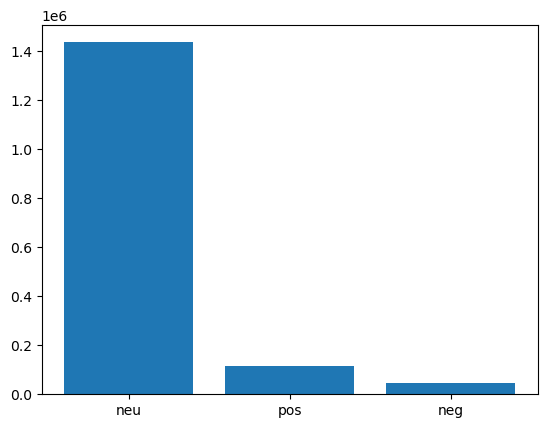

In [28]:
plot_sentiment_barchart(project['text'], method='Vader')

In [29]:
project['sentiment'] = project['text'].apply(lambda x: sentiment_textblob(x))
project.head(10)

target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       1  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       2  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       3  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       4  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
5       5  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY   
6       6  1467811592  Mon Apr 06 22:20:03 PDT 2009  NO_QUERY   
7       7  1467811594  Mon Apr 06 22:20:03 PDT 2009  NO_QUERY   
8       8  1467811795  Mon Apr 06 22:20:05 PDT 2009  NO_QUERY   
9       9  1467812025  Mon Apr 06 22:20:09 PDT 2009  NO_QUERY   

              user                                               text  \
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1    scotthamilton  is upset that he can't update his Facebook by ...   
2         mattycus  @Kenichan I dived many times for the ball. Man...   
3          ElleCTF    my whole body feels itchy and like its on fire    
4           Karoli  @nationwideclass no, it's not behaving at all....   
5         joy_wolf                      @Kwesidei not the whole crew    
6          mybirch                                        Need a hug    
7             coZZ  @LOLTrish hey  long time no see! Yes.. Rains a...   
8  2Hood4Hollywood               @Tatiana_K nope they didn't have it    
9          mimismo                          @twittera que me muera ?    

  sentiment  
0       pos  
1       neu  
2       pos  
3       pos  
4       neg  
5       pos  
6       neu  
7       pos  
8       neu  
9       neu

## Time Series

In [ ]:
# Convert the 'date' column to datetime format
project['date'] = pd.to_datetime(project['date'])

In [ ]:
# Set the 'date' column as the index
project.set_index('date', inplace=True)

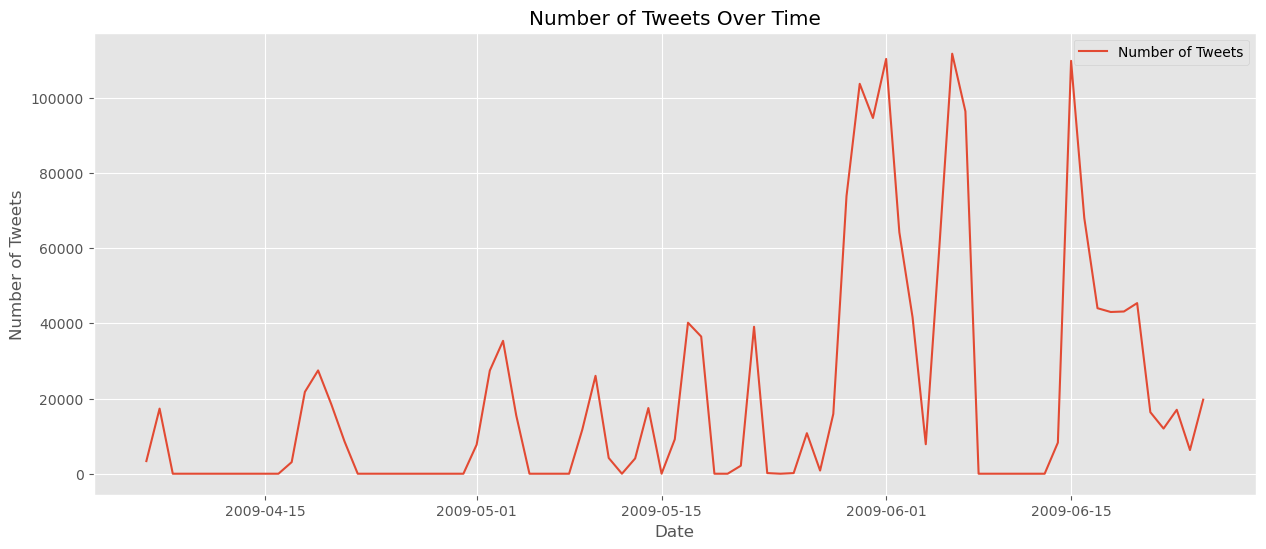

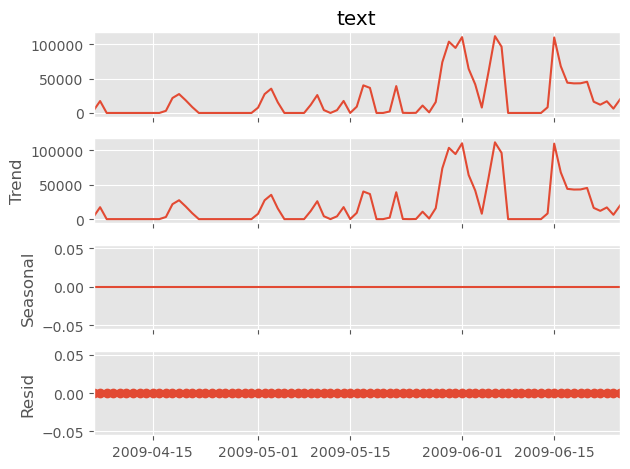

In [62]:
# Resample the data to a specific time frequency (e.g., daily)
df_resampled = project.resample('D').count()

# Plot the time series data
plt.figure(figsize=(15, 6))
plt.plot(df_resampled.index, df_resampled['text'], label='Number of Tweets')
plt.title('Number of Tweets Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.legend()
plt.show()

# Decompose the time series into trend, seasonality, and residual components
result = seasonal_decompose(df_resampled['text'], model='additive', period=1)
result.plot()
plt.show()

# Create a word cloud from the tweet text
text = ' '.join(project['text'].dropna())
stop_words = set(nltk_stopwords.words('english'))  # Use the renamed import
#tokens = word_tokenize('text')
#filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]

### Text Classification & ML Models

## ML Models

In [13]:
# write your dataset has 'text' and 'target' columns
texts = project['text']
labels = project['target']

# Tokenize the text
max_words = 10000  # Adjust this based on your dataset
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences to have consistent length
maxlen = 100  # Adjust this based on your dataset
data = pad_sequences(sequences, maxlen=maxlen)

# Build the LSTM model
model = Sequential()
model.add(Embedding(max_words, 32, input_length=maxlen))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(data, labels, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
40000/40000 [==============================] - 784s 20ms/step - loss: -425909664.0000 - accuracy: 7.8125e-07 - val_loss: -1903586304.0000 - val_accuracy: 0.0000e+00
Epoch 2/10
40000/40000 [==============================] - 776s 19ms/step - loss: -1266377984.0000 - accuracy: 7.8125e-07 - val_loss: -3794464000.0000 - val_accuracy: 0.0000e+00
Epoch 3/10
40000/40000 [==============================] - 759s 19ms/step - loss: -2106477184.0000 - accuracy: 7.8125e-07 - val_loss: -5685422080.0000 - val_accuracy: 0.0000e+00
Epoch 4/10
40000/40000 [==============================] - 748s 19ms/step - loss: -2947251456.0000 - accuracy: 7.8125e-07 - val_loss: -7576464896.0000 - val_accuracy: 0.0000e+00
Epoch 5/10
40000/40000 [==============================] - 840s 21ms/step - loss: -3787574784.0000 - accuracy: 7.8125e-07 - val_loss: -9467553792.0000 - val_accuracy: 0.0000e+00
Epoch 6/10
40000/40000 [==============================] - 778s 19ms/step - loss: -4628021248.0000 - accuracy: 7.8125

## Single LSTM

Epoch 1/5
40000/40000 [==============================] - 789s 20ms/step - loss: -8839320576.0000 - accuracy: 7.8125e-07 - val_loss: -20834007040.0000 - val_accuracy: 0.0000e+00
Epoch 2/5
40000/40000 [==============================] - 928s 23ms/step - loss: -9679622144.0000 - accuracy: 7.8125e-07 - val_loss: -22724659200.0000 - val_accuracy: 0.0000e+00
Epoch 3/5
40000/40000 [==============================] - 976s 24ms/step - loss: -10519928832.0000 - accuracy: 7.8125e-07 - val_loss: -24615274496.0000 - val_accuracy: 0.0000e+00
Epoch 4/5
40000/40000 [==============================] - 965s 24ms/step - loss: -11359754240.0000 - accuracy: 7.8125e-07 - val_loss: -26504034304.0000 - val_accuracy: 0.0000e+00
Epoch 5/5
40000/40000 [==============================] - 954s 24ms/step - loss: -12199144448.0000 - accuracy: 7.8125e-07 - val_loss: -28392761344.0000 - val_accuracy: 0.0000e+00


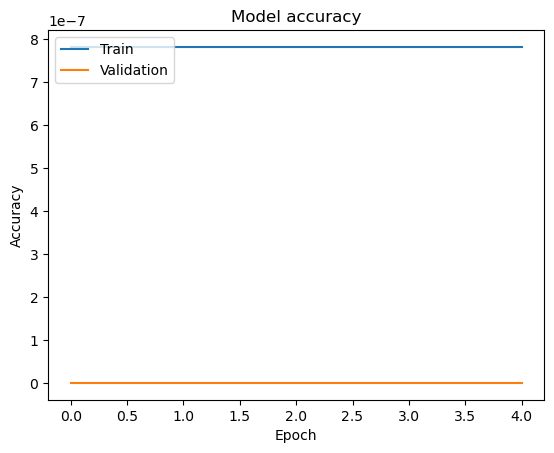

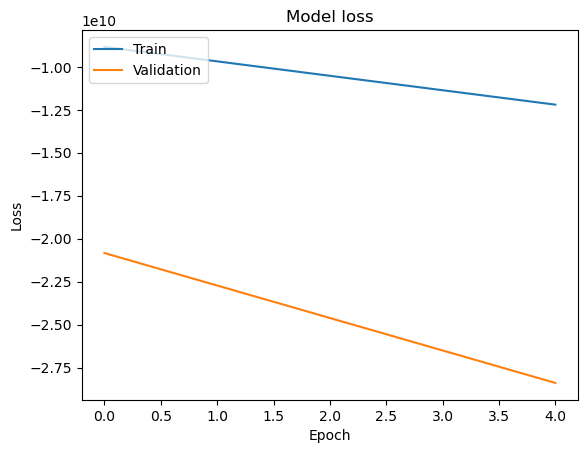

In [17]:
# Train the model and store the training history
history = model.fit(data, labels, epochs=5, batch_size=32, validation_split=0.2)

# Plot training history
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Call the function to plot the history
plot_history(history)

## Bidirectional LSTM model

Epoch 1/5
40000/40000 [==============================] - 910s 23ms/step - loss: -837667456.0000 - accuracy: 7.8125e-07 - val_loss: -3746212608.0000 - val_accuracy: 0.0000e+00
Epoch 2/5
40000/40000 [==============================] - 885s 22ms/step - loss: -2492538880.0000 - accuracy: 7.8125e-07 - val_loss: -7470696960.0000 - val_accuracy: 0.0000e+00
Epoch 3/5
40000/40000 [==============================] - 878s 22ms/step - loss: -4147995136.0000 - accuracy: 7.8125e-07 - val_loss: -11195419648.0000 - val_accuracy: 0.0000e+00
Epoch 4/5
40000/40000 [==============================] - 991s 25ms/step - loss: -5804080128.0000 - accuracy: 7.8125e-07 - val_loss: -14920741888.0000 - val_accuracy: 0.0000e+00
Epoch 5/5
40000/40000 [==============================] - 1035s 26ms/step - loss: -7459528704.0000 - accuracy: 7.8125e-07 - val_loss: -18645215232.0000 - val_accuracy: 0.0000e+00


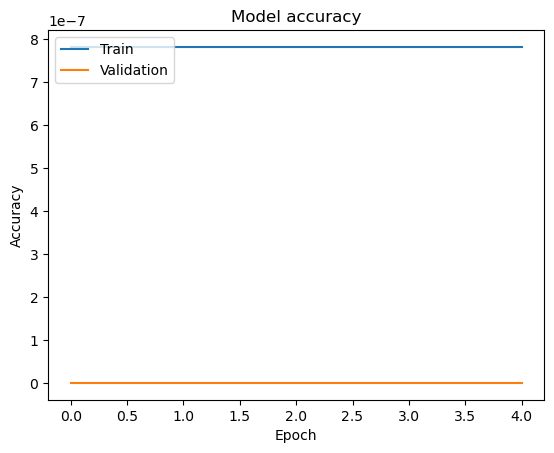

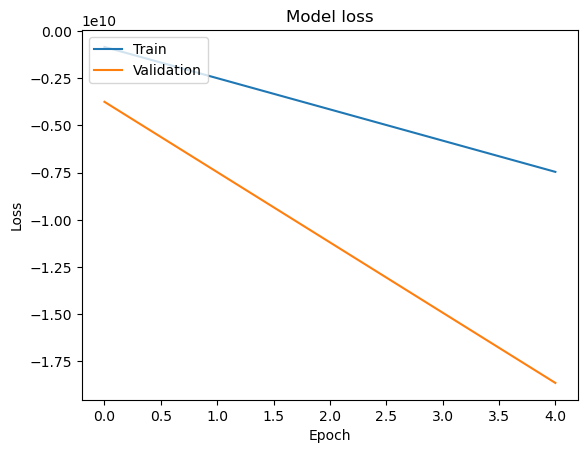

In [5]:
# write your dataset has 'text' and 'target' columns
texts = project['text']
labels = project['target']

# Tokenize the text
max_words = 10000  # Adjust this based on your dataset
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences to have consistent length
maxlen = 100  # Adjust this based on your dataset
data = pad_sequences(sequences, maxlen=maxlen)

# Build the Bidirectional LSTM model
model = Sequential()
model.add(Embedding(max_words, 32, input_length=maxlen))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store the training history
history = model.fit(data, labels, epochs=5, batch_size=32, validation_split=0.2)

# Plot training history
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Call the function to plot the history
plot_history(history)

## Convolutional Neural Network (CNN)

Epoch 1/5
32000/32000 [==============================] - 217s 7ms/step - loss: -69884134293504.0000 - accuracy: 9.7656e-07 - val_loss: -253243250704384.0000 - val_accuracy: 0.0000e+00
Epoch 2/5
32000/32000 [==============================] - 229s 7ms/step - loss: -827257878740992.0000 - accuracy: 9.7656e-07 - val_loss: -1675820674318336.0000 - val_accuracy: 0.0000e+00
Epoch 3/5
32000/32000 [==============================] - 232s 7ms/step - loss: -3232240184066048.0000 - accuracy: 9.7656e-07 - val_loss: -5220402825527296.0000 - val_accuracy: 0.0000e+00
Epoch 4/5
32000/32000 [==============================] - 226s 7ms/step - loss: -8229592741445632.0000 - accuracy: 9.7656e-07 - val_loss: -11823583256903680.0000 - val_accuracy: 0.0000e+00
Epoch 5/5
32000/32000 [==============================] - 227s 7ms/step - loss: -16753711791472640.0000 - accuracy: 9.7656e-07 - val_loss: -22417564621602816.0000 - val_accuracy: 0.0000e+00


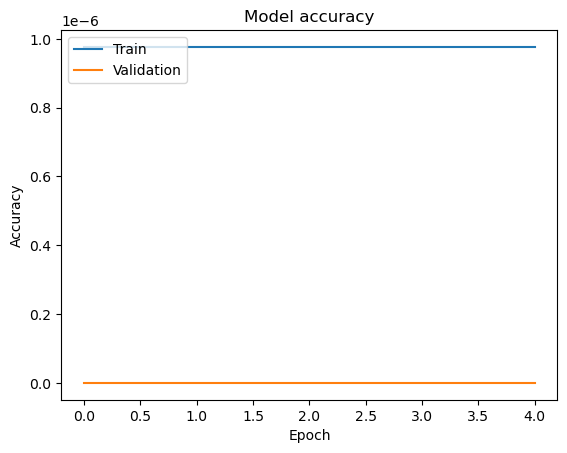

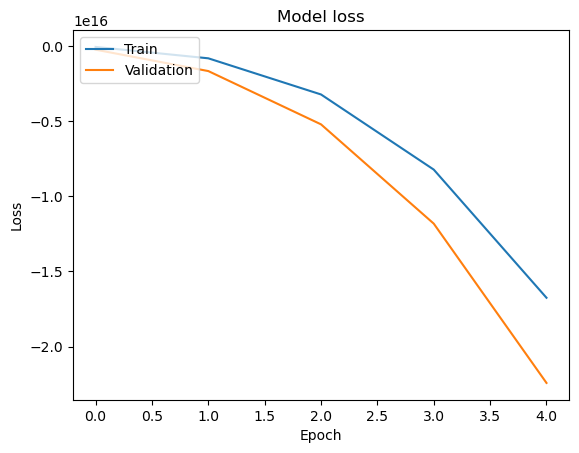

10000/10000 [==============================] - 28s 3ms/step
CNN Accuracy: 0.0


c:\Users\tolga\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\tolga\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\tolga\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\tolga\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_

In [9]:
# write your dataset has 'text' and 'target' columns
texts = project['text']
labels = project['target']

# Tokenize and pad sequences
max_words = 10000
maxlen = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X_padded = pad_sequences(sequences, maxlen=maxlen)

# Split the data into training and testing sets
X_train_padded, X_test_padded, y_train, y_test = train_test_split(X_padded, labels, test_size=0.2, random_state=42)

# Build the CNN model
model = Sequential()
model.add(Embedding(max_words, 32, input_length=maxlen))
model.add(Conv1D(64, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store the training history
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Plot training history
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Call the function to plot the history
plot_history(history)

# Evaluate accuracy on the test set
y_pred = model.predict(X_test_padded)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'CNN Accuracy: {accuracy}')

## Confusion matrix

In [30]:
project.head()

target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       1  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       2  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       3  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       4  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  \
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1    scotthamilton  is upset that he can't update his Facebook by ...   
2         mattycus  @Kenichan I dived many times for the ball. Man...   
3          ElleCTF    my whole body feels itchy and like its on fire    
4           Karoli  @nationwideclass no, it's not behaving at all....   

  sentiment  
0       pos  
1       neu  
2       pos  
3       pos  
4       neg

c:\Users\tolga\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\tolga\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\tolga\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\tolga\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_

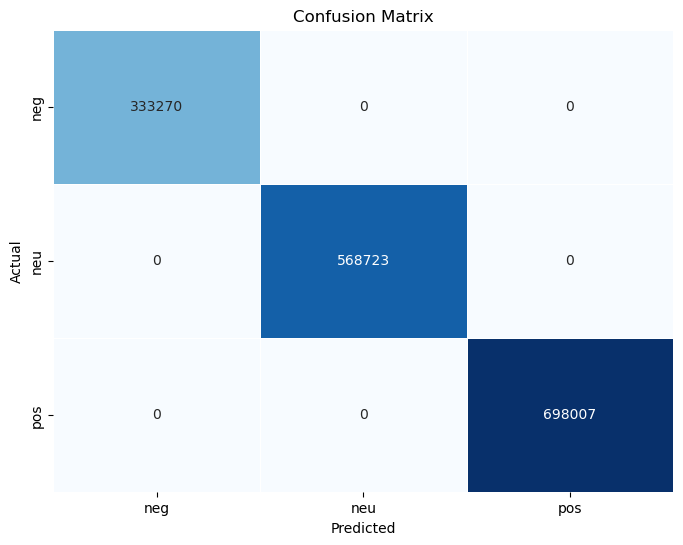

In [39]:
# Assuming your data is stored in a DataFrame named 'project'
actual_labels = project['sentiment']
predicted_labels = project['sentiment']  # actual column name is 'sentiment' 

# Calculate confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)

# Create a DataFrame for better visualization, positive,negative and neutral
conf_df = pd.DataFrame(conf_matrix, index=['neg', 'neu', 'pos'], columns=['neg', 'neu', 'pos'])

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
